In [1]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)


/home/javitrucas/miniconda3/envs/tfg/bin/python


In [3]:
# Importaciones necesarias
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

# Agregar la ruta de los scripts al sistema
sys.path.append(os.path.abspath("../scripts"))
sys.path.append(os.path.abspath("../"))

# Importar el modelo y las clases de datasets
from scripts.model import MILModel
from data.datasets.SCStandardMILDataset import SCStandardMILDataset
from data.datasets.MCStandardMILDataset import MCStandardMILDataset
from data.datasets.MCStandard_MIO import MCStandard_MIO
from data.datasets.FalseFrequencyMILDataset import FalseFrequencyMILDataset


In [4]:
# Configuración general
DATA_DIR = "../data/datasets"  # Carpeta donde están los datasets
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# BATCH_SIZE = 1
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
FEATURE_DIM = 2
POOLING_TYPE = "attention"  # Opciones: 'attention', 'mean', 'max'

# Parámetros específicos de los datasets
D = FEATURE_DIM  # Dimensionalidad de los datos
NUM_BAGS = 100  # Número de bolsas
B = 3  # Número de instancias negativas por bolsa
POS_CLASS_PROB = 0.5  # Probabilidad de que una bolsa sea positiva
SEED = 42  # Semilla para reproducibilidad


In [5]:
def train_model(loader, model, criterion, optimizer, epochs=NUM_EPOCHS):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for bag_data, bag_label, instance_labels, adj_mat, mask in loader:
            bag_data = bag_data.to(DEVICE)
            bag_label = bag_label.float().unsqueeze(-1).to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None

            optimizer.zero_grad()
            predictions, _ = model(bag_data, mask=mask)

            # Si usas BCEWithLogitsLoss, no apliques sigmoid aquí
            loss = criterion(predictions, bag_label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


In [6]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix
)

def evaluate_model(loader, model, threshold=0.5):
    model.eval()
    all_labels, all_probs, all_preds = [], [], []
    with torch.no_grad():
        for X, y, *_ , mask in loader:
            X = X.to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None

            logits, _ = model(X, mask=mask)
            probs = torch.sigmoid(logits).cpu().squeeze(-1).tolist()
            if isinstance(probs, float):
                probs = [probs]
            preds = [int(p > threshold) for p in probs]

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy().tolist())

    # Métricas
    acc = accuracy_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float('nan')
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, zero_division=0)

    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    return {'accuracy': acc, 'auc': auc, 'f1': f1, 'confusion_matrix': cm}


In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np


def visualizar_bolsas(dataset, max_bolsas=None):
    """
    Visualiza bolsas de datos en 2D, indicando bolsas positivas/negativas,
    instancias positivas y posibles instancias envenenadas.

    Args:
        dataset: Lista de tuplas (bag_data, bag_label, inst_labels, adj_mat)
        max_bolsas: Número máximo de bolsas a visualizar (opcional)
    """
    num_bolsas = len(dataset) if max_bolsas is None else min(
        len(dataset), max_bolsas)
    fig, axes = plt.subplots(1, num_bolsas, figsize=(5 * num_bolsas, 5))

    if num_bolsas == 1:
        axes = [axes]

    for idx, ax in enumerate(axes):
        bag_data, bag_label, inst_labels, _ = dataset[idx]

        bag_data_np = bag_data.numpy()
        inst_labels_np = inst_labels.numpy()

        titulo_bolsa = 'Positiva' if bag_label.item() == 1 else 'Negativa'
        color_base = 'blue' if bag_label.item() == 1 else 'red'

        # Definir grupos de instancias (máscara, color, etiqueta, tamaño, borde)
        grupos = [(inst_labels_np == 0, color_base, 'Instancias Negativas', 40,
                   None),
                  (inst_labels_np == 1, 'green', 'Instancias Positivas', 100,
                   'black'),
                  (inst_labels_np == -1, 'purple', 'Instancias Envenenadas',
                   100, 'black')]

        for mask, color, label, size, edge in grupos:
            puntos = bag_data_np[mask]
            if len(puntos) > 0:
                ax.scatter(puntos[:, 0],
                           puntos[:, 1],
                           c=color,
                           s=size,
                           edgecolors=edge if edge else 'none',
                           label=label,
                           alpha=0.6)

        ax.set_title(f'Bolsa {idx + 1} ({titulo_bolsa})')
        ax.set_xlabel('Dimensión 1')
        ax.set_ylabel('Dimensión 2')

        # Evitar duplicados en la leyenda
        handles, labels = ax.get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        ax.legend(unique.values(), unique.keys())

    plt.tight_layout()
    plt.show()

SC Standard Dataset

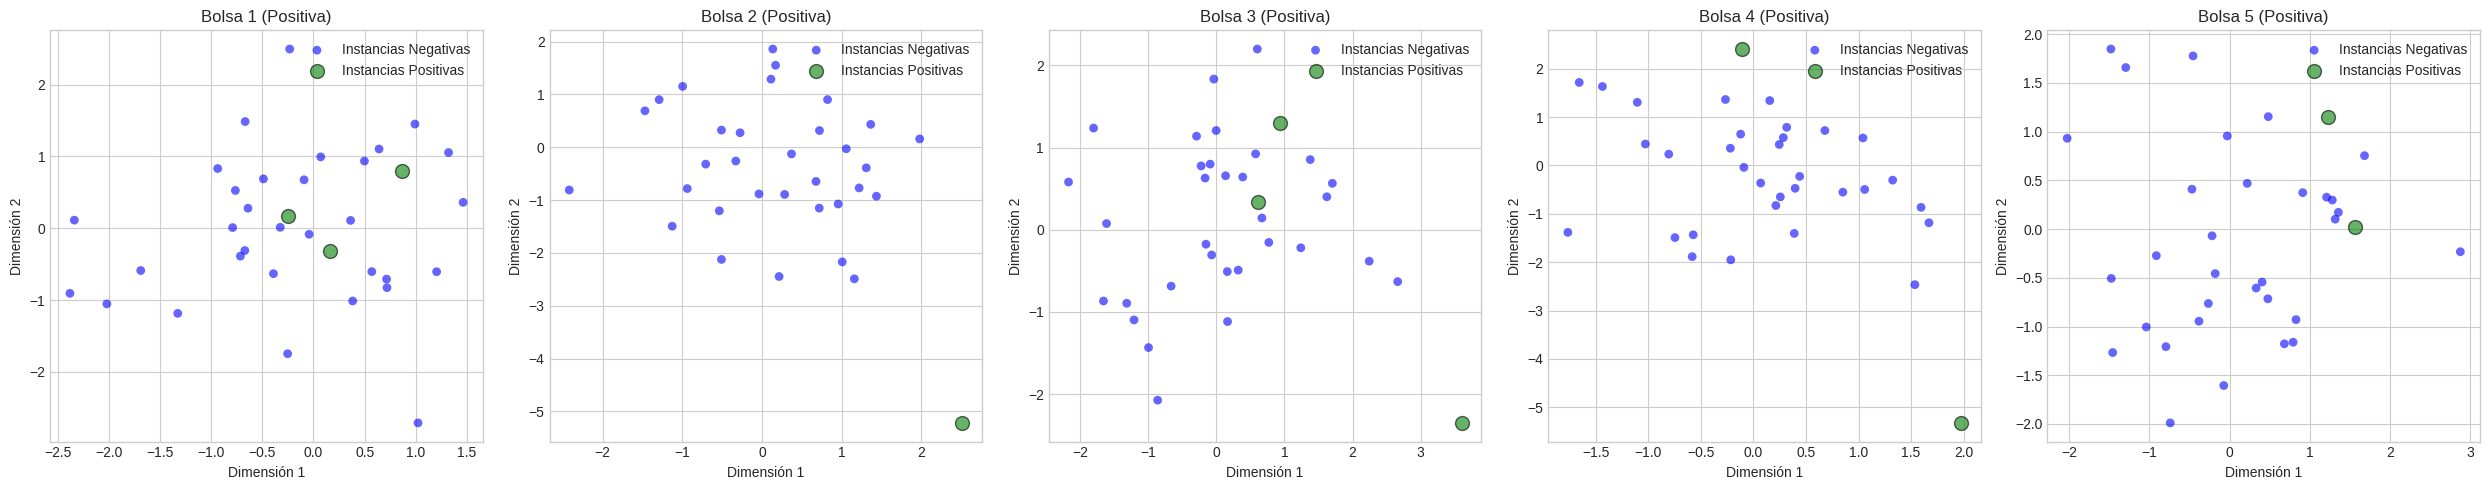

In [26]:
sc_dataset = SCStandardMILDataset(
    D=FEATURE_DIM,
    num_bags=NUM_BAGS,
    B=B
)

sc_dataset_test = SCStandardMILDataset(
    D=FEATURE_DIM,
    num_bags=NUM_BAGS,
    B=B,
    train=False
)

sc_loader = DataLoader(sc_dataset,
                       shuffle=True,
                       collate_fn=sc_dataset.collate_fn)
sc_test_loader = DataLoader(sc_dataset_test,
                           shuffle=False,
                           collate_fn=sc_dataset_test.collate_fn)

# Visualizar bolsas

visualizar_bolsas(sc_dataset, max_bolsas=5)

In [29]:
criterion = torch.nn.BCELoss()

# Ejemplo para SCStandard
print("=== Entrenando en SCStandard Dataset ===")
model = MILModel(input_feature_dim=FEATURE_DIM, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(sc_loader, model,criterion , optimizer)

print("=== Evaluando en TRAIN - SCStandard Dataset ===")
evaluate_model(sc_loader, model)

print("=== Evaluando en TEST - SCStandard Dataset ===")
evaluate_model(sc_test_loader, model)

=== Entrenando en SCStandard Dataset ===
Epoch 1/10, Loss: 87.7767
Epoch 2/10, Loss: 26.2355
Epoch 3/10, Loss: 18.2371
Epoch 4/10, Loss: 14.4254
Epoch 5/10, Loss: 12.9049
Epoch 6/10, Loss: 10.0153
Epoch 7/10, Loss: 18.4786
Epoch 8/10, Loss: 10.3438
Epoch 9/10, Loss: 4.9099
Epoch 10/10, Loss: 3.0902
=== Evaluando en TRAIN - SCStandard Dataset ===
Accuracy: 1.0000, AUC: 1.0000, F1-Score: 1.0000
Confusion Matrix:
[[250   0]
 [  0 250]]
=== Evaluando en TEST - SCStandard Dataset ===
Accuracy: 0.0020, AUC: 0.0007, F1-Score: 0.0040
Confusion Matrix:
[[  0 250]
 [249   1]]


{'accuracy': 0.002, 'auc': 0.0006880000000000001, 'f1': 0.003992015968063872}

MC Standard Dataset

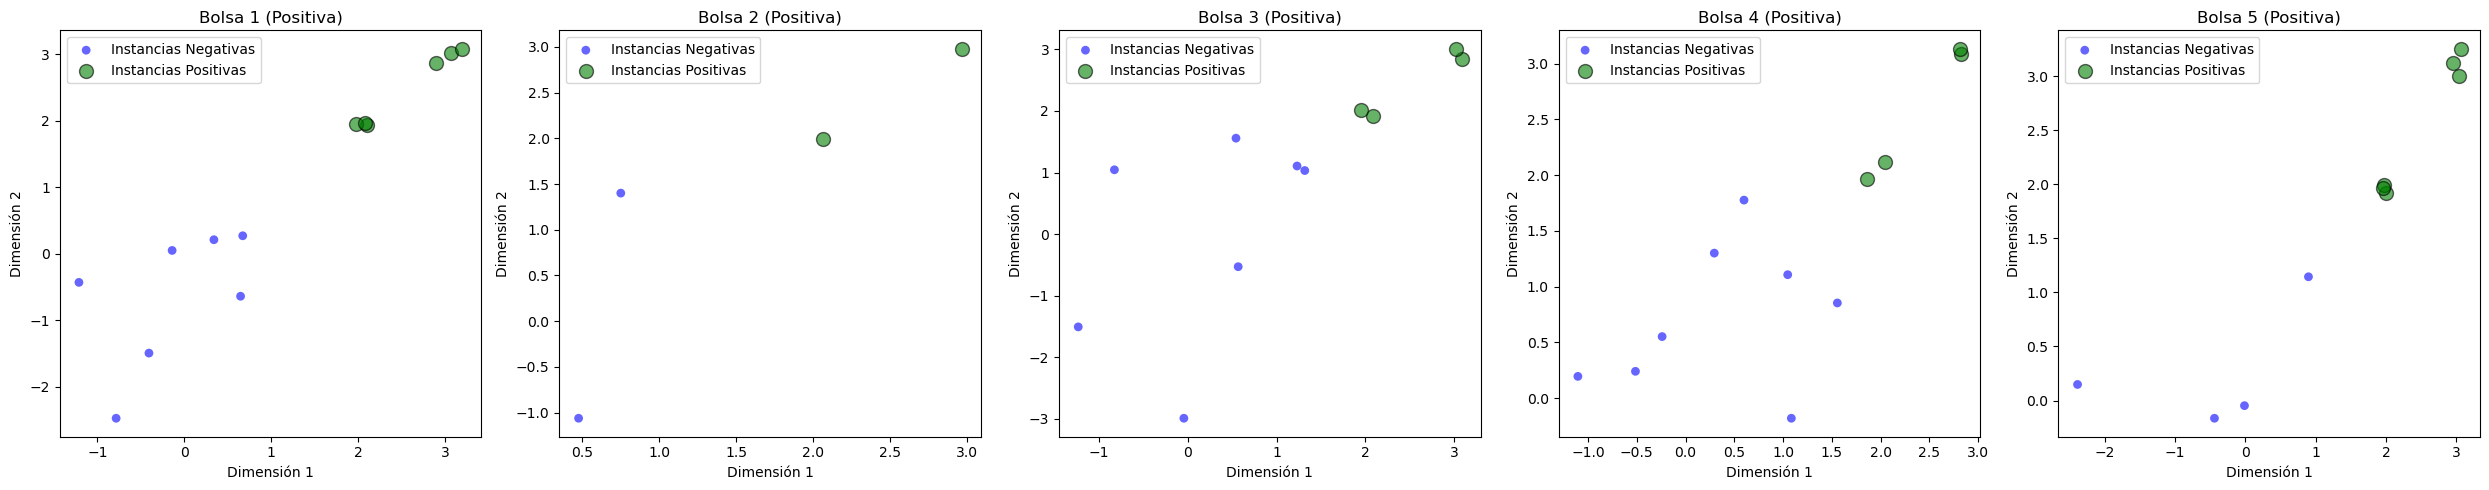

In [9]:
mc_dataset = MCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B
)

mc_test_dataset = MCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    train=False
)

mc_loader = DataLoader(mc_dataset, shuffle=True, collate_fn=mc_dataset.collate_fn)
mc_test_loader  =  DataLoader(mc_test_dataset, shuffle=False, collate_fn=mc_dataset.collate_fn)

visualizar_bolsas(mc_dataset, max_bolsas = 5)

In [16]:
criterion = torch.nn.BCELoss()

# Ejemplo para MCStandard
print("=== Entrenando en MCStandard Dataset ===")
model = MILModel(input_feature_dim=D, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(mc_loader, model,criterion , optimizer)

print("=== Evaluando en TRAIN - MCStandard Dataset ===")
evaluate_model(mc_loader, model)

print("=== Evaluando en TEST - MCStandard Dataset ===")
evaluate_model(mc_test_loader, model)


=== Entrenando en MCStandard Dataset ===
Epoch 1/10, Loss: 24.6460
Epoch 2/10, Loss: 4.0209
Epoch 3/10, Loss: 1.0620
Epoch 4/10, Loss: 0.3624
Epoch 5/10, Loss: 0.3052
Epoch 6/10, Loss: 0.2226
Epoch 7/10, Loss: 0.1564
Epoch 8/10, Loss: 0.1555
Epoch 9/10, Loss: 5.0325
Epoch 10/10, Loss: 0.6009
=== Evaluando en TRAIN - MCStandard Dataset ===
Accuracy: 1.0000, AUC: 1.0000, F1-Score: 1.0000
AUC ROC:  1.0
F1 Score:  1.0
Confusion Matrix:
[[50  0]
 [ 0 50]]
=== Evaluando en TEST - MCStandard Dataset ===
Accuracy: 0.0000, AUC: 0.0000, F1-Score: 0.0000
AUC ROC:  0.0
F1 Score:  0.0
Confusion Matrix:
[[ 0 50]
 [50  0]]


MI MCSTANDARD

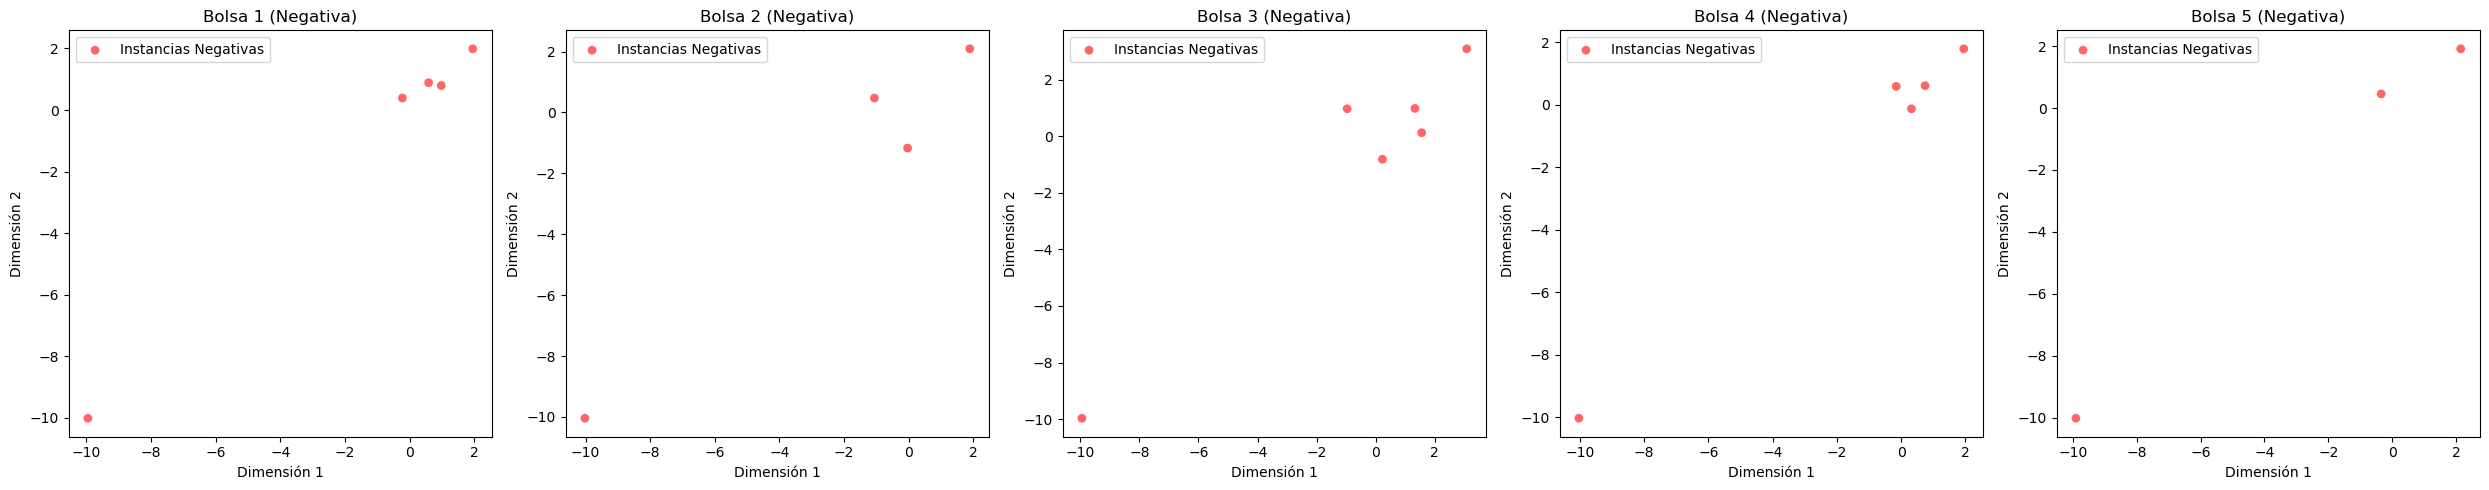

In [9]:
import torch
from torch.utils.data import DataLoader

# Parámetros
D = 16
NUM_BAGS = 1000
B = None  # MCStandard no usa B fijo, lo omites o pásalo como None

# Entrenamiento
mc_dataset = MCStandard_MIO(
    D=D,
    train_size=NUM_BAGS,
    test_size=None,
    min_size=None,
    v2=False,
    train=True,
    seed=42
)

# Test
mc_test_dataset = MCStandard_MIO(
    D=D,
    train_size=None,
    test_size=NUM_BAGS,
    min_size=None,
    v2=False,
    train=False,
    seed=42
)

# DataLoaders
mc_loader = DataLoader(
    mc_dataset,
    shuffle=True,
    batch_size=1,  # O el que uses habitualmente
    collate_fn=mc_dataset.collate_fn
)
mc_test_loader = DataLoader(
    mc_test_dataset,
    shuffle=False,
    batch_size=1,
    collate_fn=mc_test_dataset.collate_fn
)

# Visualizar algunas bolsas
visualizar_bolsas(mc_dataset, max_bolsas=5)


In [11]:
# Definir criterio, modelo y optimizador
criterion = torch.nn.BCELoss()
model = MILModel(input_feature_dim=D, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Entrenamiento
print("=== Entrenando en MCStandard Dataset ===")
train_model(mc_loader, model, criterion, optimizer)

# Evaluación en train
print("=== Evaluando en TRAIN - MCStandard Dataset ===")
evaluate_model(mc_loader, model)

# Evaluación en test
print("=== Evaluando en TEST - MCStandard Dataset ===")
evaluate_model(mc_test_loader, model)

=== Entrenando en MCStandard Dataset ===


/opt/conda/conda-bld/pytorch_1729647369228/work/aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [0,0,0] Assertion `input_val >= zero && input_val <= one` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


False Frequency Dataset

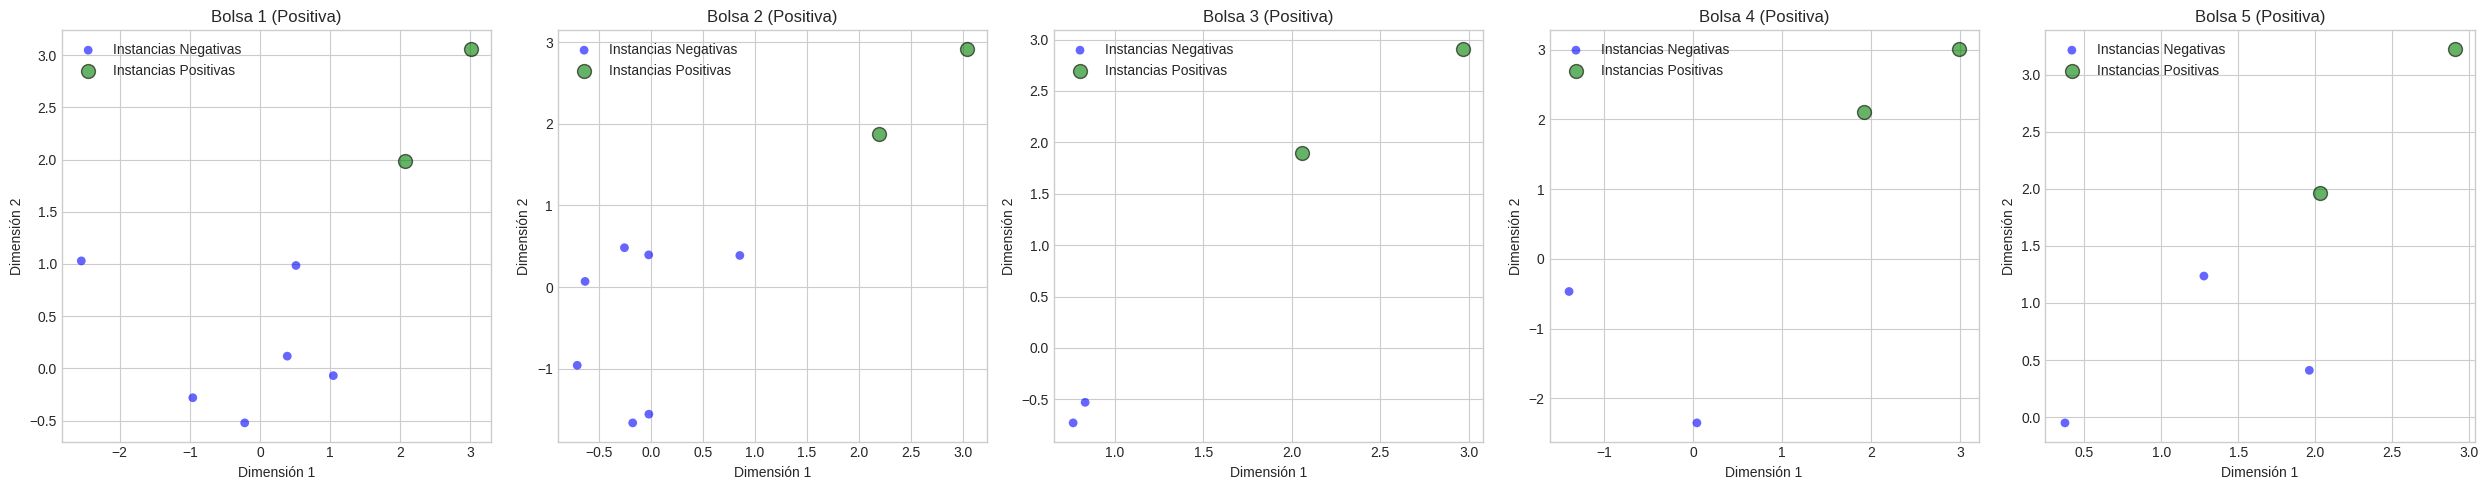

In [10]:
ff_dataset =FalseFrequencyMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B
)

ff_test_dataset =FalseFrequencyMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B, 
    train = False
)
 

ff_loader = DataLoader(ff_dataset, shuffle=True, collate_fn=ff_dataset.collate_fn)
ff_test_loader = DataLoader(ff_test_dataset, shuffle=False, collate_fn=ff_test_dataset.collate_fn)

# Visualizar bolsas
visualizar_bolsas(ff_dataset, max_bolsas=5)


In [13]:
criterion = torch.nn.BCELoss()

# Ejemplo para FalseFrequency
print("=== Entrenando en FalseFrequency Dataset ===")
model = MILModel(input_feature_dim=D, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(ff_loader, model,criterion , optimizer)

print("=== Evaluando en TRAIN - FalseFrequency Dataset ===")
evaluate_model(ff_loader, model)

print("=== Evaluando en TEST - FalseFrequency Dataset ===")
evaluate_model(ff_test_loader, model)

=== Entrenando en FalseFrequency Dataset ===


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


PRUEBAS 

In [9]:
import csv
import numpy as np
import torch
from torch.utils.data import DataLoader

# Parámetros
datasets = ['SCStandard', 'MCStandard', 'FalseFrequency']
n_bags_list = [50, 100, 500, 1000]
pooling_modes = ['attention', 'mean', 'max']
FEATURE_DIM = 128
B = 25
LEARNING_RATE = 1e-3
REPEATS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CSV de resultados
csv_file = "suposiciones.csv"
header = [
    "dataset", "n_bags", "pooling_type",
    "accuracy_train", "accuracy_test",
    "auc_train", "auc_test",
    "f1_train", "f1_test"
]

with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)

    # Bucle principal
    for pooling_type in pooling_modes:
        for dataset_name in datasets:
            for num_bags in n_bags_list:
                # Listas para acumular métricas
                acc_train_list, acc_test_list = [], []
                auc_train_list, auc_test_list = [], []
                f1_train_list, f1_test_list = [], []

                for run in range(REPEATS):
                    # Selección del dataset
                    if dataset_name == "SCStandard":
                        train_ds = SCStandardMILDataset(D=FEATURE_DIM, num_bags=num_bags, B=B)
                        test_ds = SCStandardMILDataset(D=FEATURE_DIM, num_bags=num_bags, B=B, train=False)
                    elif dataset_name == "MCStandard":
                        train_ds = MCStandardMILDataset(D=FEATURE_DIM, num_bags=num_bags, B=B)
                        test_ds = MCStandardMILDataset(D=FEATURE_DIM, num_bags=num_bags, B=B, train=False)
                    else:  # FalseFrequency
                        train_ds = FalseFrequencyMILDataset(D=FEATURE_DIM, num_bags=num_bags, B=B)
                        test_ds = FalseFrequencyMILDataset(D=FEATURE_DIM, num_bags=num_bags, B=B, train=False)

                    # DataLoaders
                    train_loader = DataLoader(train_ds, shuffle=True, collate_fn=train_ds.collate_fn)
                    test_loader = DataLoader(test_ds, shuffle=False, collate_fn=test_ds.collate_fn)

                    # Modelo, criterio y optimizador
                    criterion = torch.nn.BCEWithLogitsLoss()
                    model = MILModel(input_feature_dim=FEATURE_DIM, pooling_type=pooling_type).to(DEVICE)
                    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

                    # Entrenamiento
                    train_model(train_loader, model, criterion, optimizer)

                    # Evaluación
                    metrics_train = evaluate_model(train_loader, model)
                    metrics_test = evaluate_model(test_loader, model)

                    # Acumular métricas
                    acc_train_list.append(metrics_train['accuracy'])
                    auc_train_list.append(metrics_train['auc'])
                    f1_train_list.append(metrics_train['f1'])
                    acc_test_list.append(metrics_test['accuracy'])
                    auc_test_list.append(metrics_test['auc'])
                    f1_test_list.append(metrics_test['f1'])

                # Calcular medias
                avg_acc_train = np.mean(acc_train_list)
                avg_auc_train = np.mean(auc_train_list)
                avg_f1_train = np.mean(f1_train_list)
                avg_acc_test = np.mean(acc_test_list)
                avg_auc_test = np.mean(auc_test_list)
                avg_f1_test = np.mean(f1_test_list)

                # Guardar en CSV
                writer.writerow([
                    dataset_name,
                    num_bags,
                    pooling_type,
                    f"{avg_acc_train:.4f}",
                    f"{avg_acc_test:.4f}",
                    f"{avg_auc_train:.4f}",
                    f"{avg_auc_test:.4f}",
                    f"{avg_f1_train:.4f}",
                    f"{avg_f1_test:.4f}"
                ])

print(f"Resultados promedio guardados en {csv_file}")


Epoch 1/10, Loss: 33.6681
Epoch 2/10, Loss: 29.2902
Epoch 3/10, Loss: 28.6703
Epoch 4/10, Loss: 27.9205
Epoch 5/10, Loss: 28.0011
Epoch 6/10, Loss: 27.1392
Epoch 7/10, Loss: 26.8742
Epoch 8/10, Loss: 26.8518
Epoch 9/10, Loss: 26.6227
Epoch 10/10, Loss: 26.2100
Accuracy: 1.0000, AUC: 1.0000, F1: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Confusion Matrix:
 [[25  0]
 [ 0 25]]
Accuracy: 0.0000, AUC: 0.0000, F1: 0.0000
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      25.0
           1       0.00      0.00      0.00      25.0

    accuracy                           0.00      50.0
   macro avg       0.00 

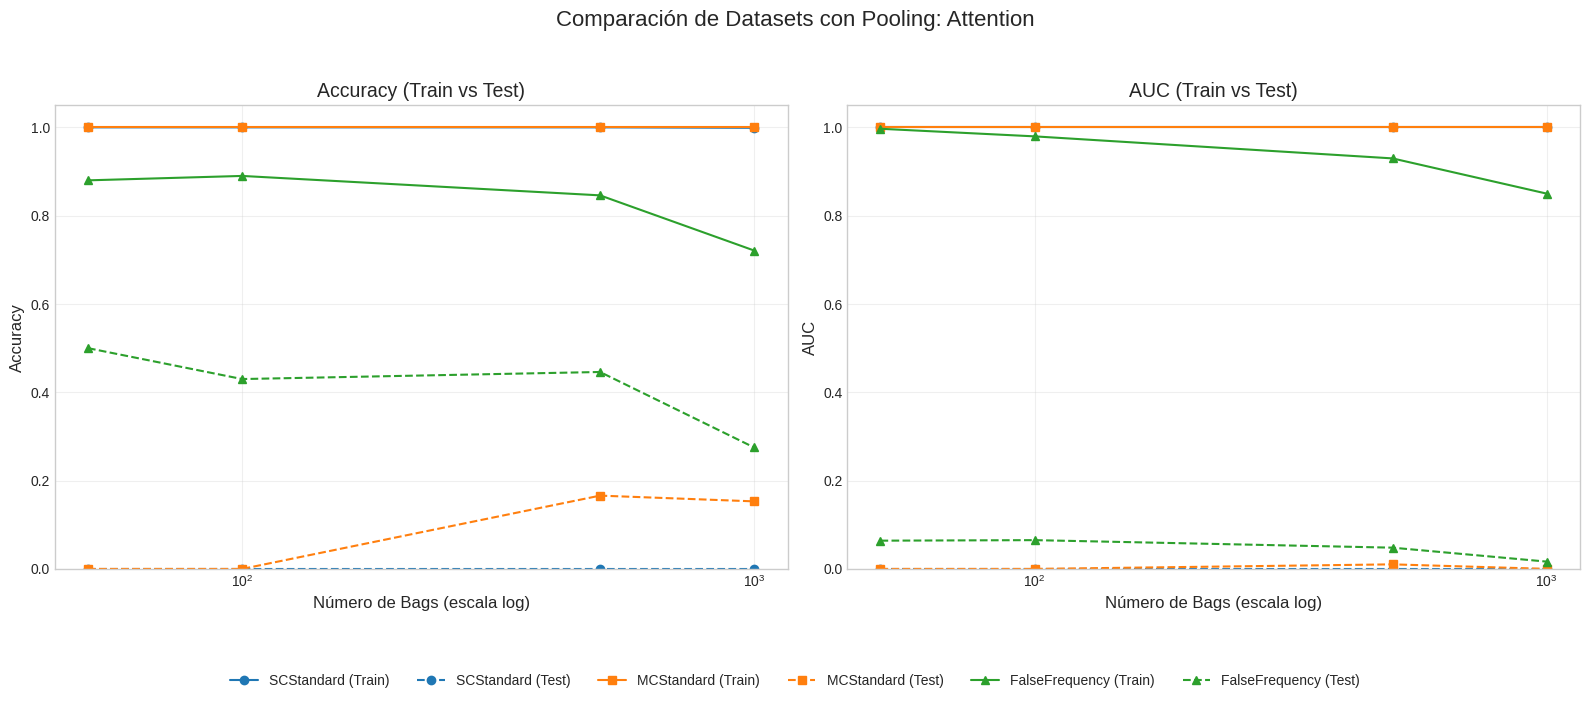

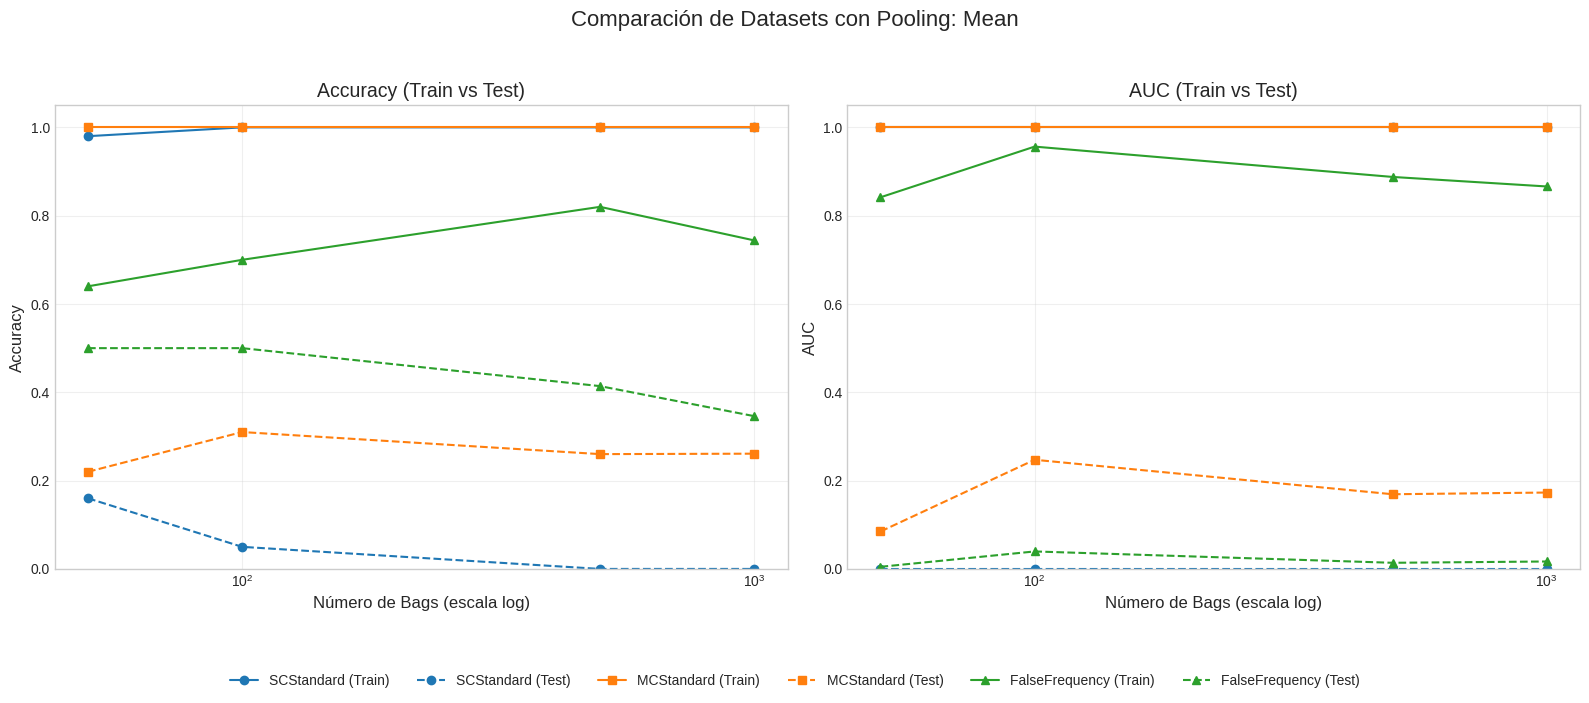

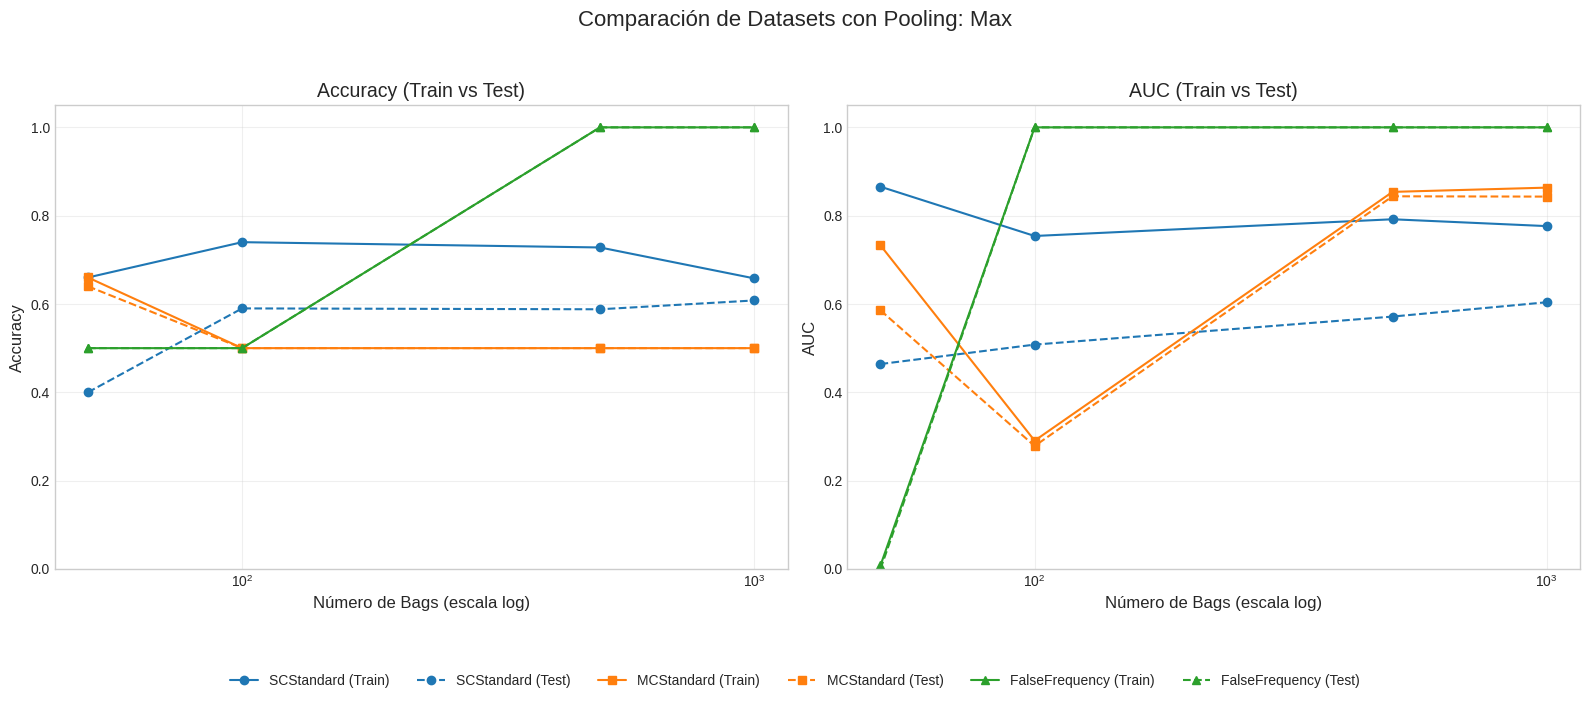

<Figure size 1800x1000 with 0 Axes>

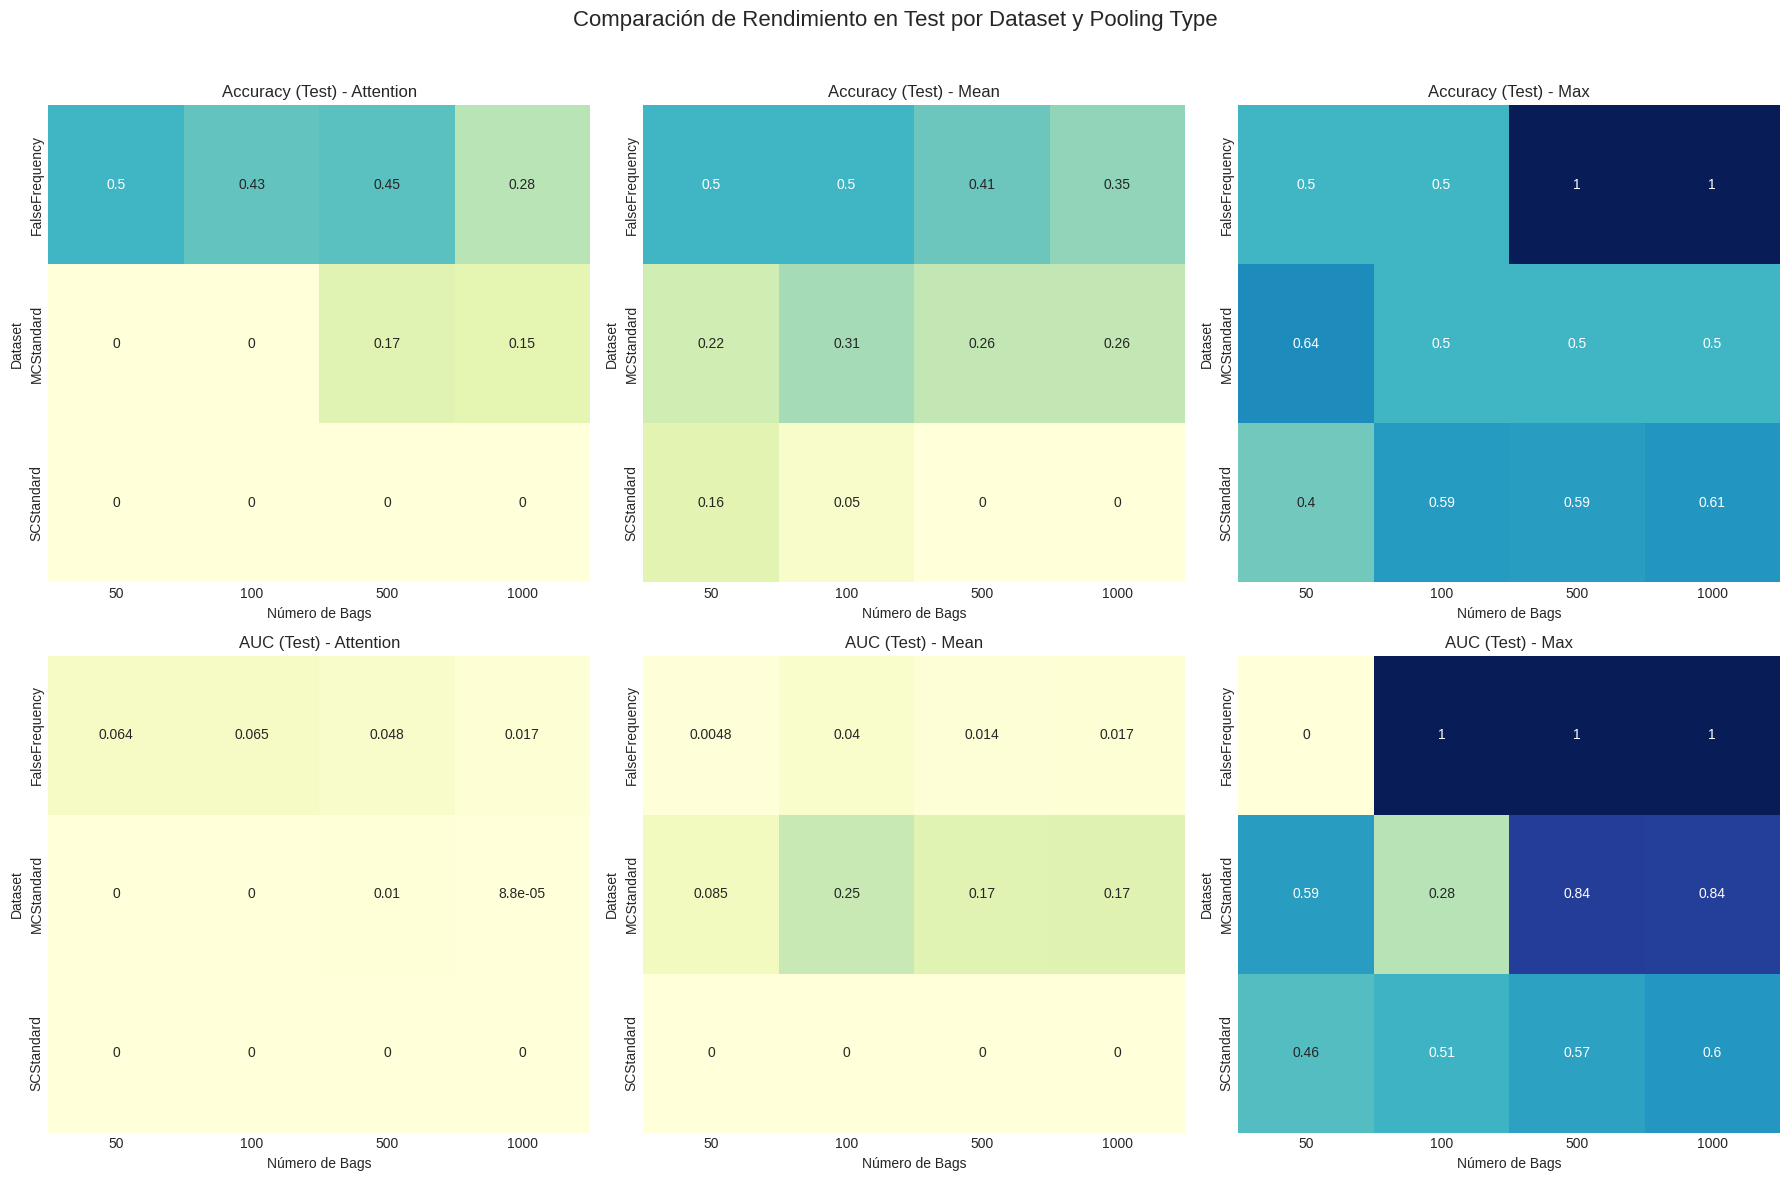

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el archivo CSV
df = pd.read_csv('suposiciones.csv')

# Configurar el estilo
plt.style.use('seaborn-v0_8-whitegrid')
colors = {'SCStandard': '#1f77b4', 'MCStandard': '#ff7f0e', 'FalseFrequency': '#2ca02c'}
markers = {'SCStandard': 'o', 'MCStandard': 's', 'FalseFrequency': '^'}

# Función para crear gráficas por tipo de pooling
def plot_by_pooling(pooling_type):
    # Filtrar datos por tipo de pooling
    data = df[df['pooling_type'] == pooling_type]
    
    # Crear figura con 2 subplots (accuracy y auc)
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Título principal
    fig.suptitle(f'Comparación de Datasets con Pooling: {pooling_type.capitalize()}', fontsize=16)
    
    # Lista de datasets
    datasets = data['dataset'].unique()
    
    # Gráfica para Accuracy
    for dataset in datasets:
        dataset_data = data[data['dataset'] == dataset]
        axes[0].plot(dataset_data['n_bags'], dataset_data['accuracy_train'], 
                  color=colors[dataset], marker=markers[dataset], linestyle='-', 
                  label=f'{dataset} (Train)')
        axes[0].plot(dataset_data['n_bags'], dataset_data['accuracy_test'], 
                  color=colors[dataset], marker=markers[dataset], linestyle='--',
                  label=f'{dataset} (Test)')
    
    axes[0].set_xscale('log')
    axes[0].set_xlabel('Número de Bags (escala log)', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Accuracy (Train vs Test)', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1.05)
    
    # Gráfica para AUC
    for dataset in datasets:
        dataset_data = data[data['dataset'] == dataset]
        axes[1].plot(dataset_data['n_bags'], dataset_data['auc_train'], 
                  color=colors[dataset], marker=markers[dataset], linestyle='-', 
                  label=f'{dataset} (Train)')
        axes[1].plot(dataset_data['n_bags'], dataset_data['auc_test'], 
                  color=colors[dataset], marker=markers[dataset], linestyle='--',
                  label=f'{dataset} (Test)')
    
    axes[1].set_xscale('log')
    axes[1].set_xlabel('Número de Bags (escala log)', fontsize=12)
    axes[1].set_ylabel('AUC', fontsize=12)
    axes[1].set_title('AUC (Train vs Test)', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1.05)
    
    # Leyenda única
    handles, labels = axes[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', 
              bbox_to_anchor=(0.5, 0.05), ncol=len(by_label), fontsize=10)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

# Ejecutar visualizaciones
# 1. Gráficas por tipo de pooling
for pooling in ['attention', 'mean', 'max']:
    plot_by_pooling(pooling)
    
# 2. Gráfica de barras para comparar el rendimiento de test entre modelos
plt.figure(figsize=(18, 10))

# Crear una matriz para organizar los subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación de Rendimiento en Test por Dataset y Pooling Type', fontsize=16)

metrics = ['accuracy_test', 'auc_test']
metric_names = ['Accuracy (Test)', 'AUC (Test)']
pooling_types = ['attention', 'mean', 'max']

for i, metric in enumerate(metrics):
    for j, pooling in enumerate(pooling_types):
        # Filtrar datos
        data = df[df['pooling_type'] == pooling]
        
        # Crear DataFrame pivotado para la visualización
        pivot_data = data.pivot(index='dataset', columns='n_bags', values=metric)
        
        # Crear heatmap
        sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', vmin=0, vmax=1, 
                   ax=axes[i, j], cbar=False)
        
        axes[i, j].set_title(f'{metric_names[i]} - {pooling.capitalize()}')
        axes[i, j].set_ylabel('Dataset')
        axes[i, j].set_xlabel('Número de Bags')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

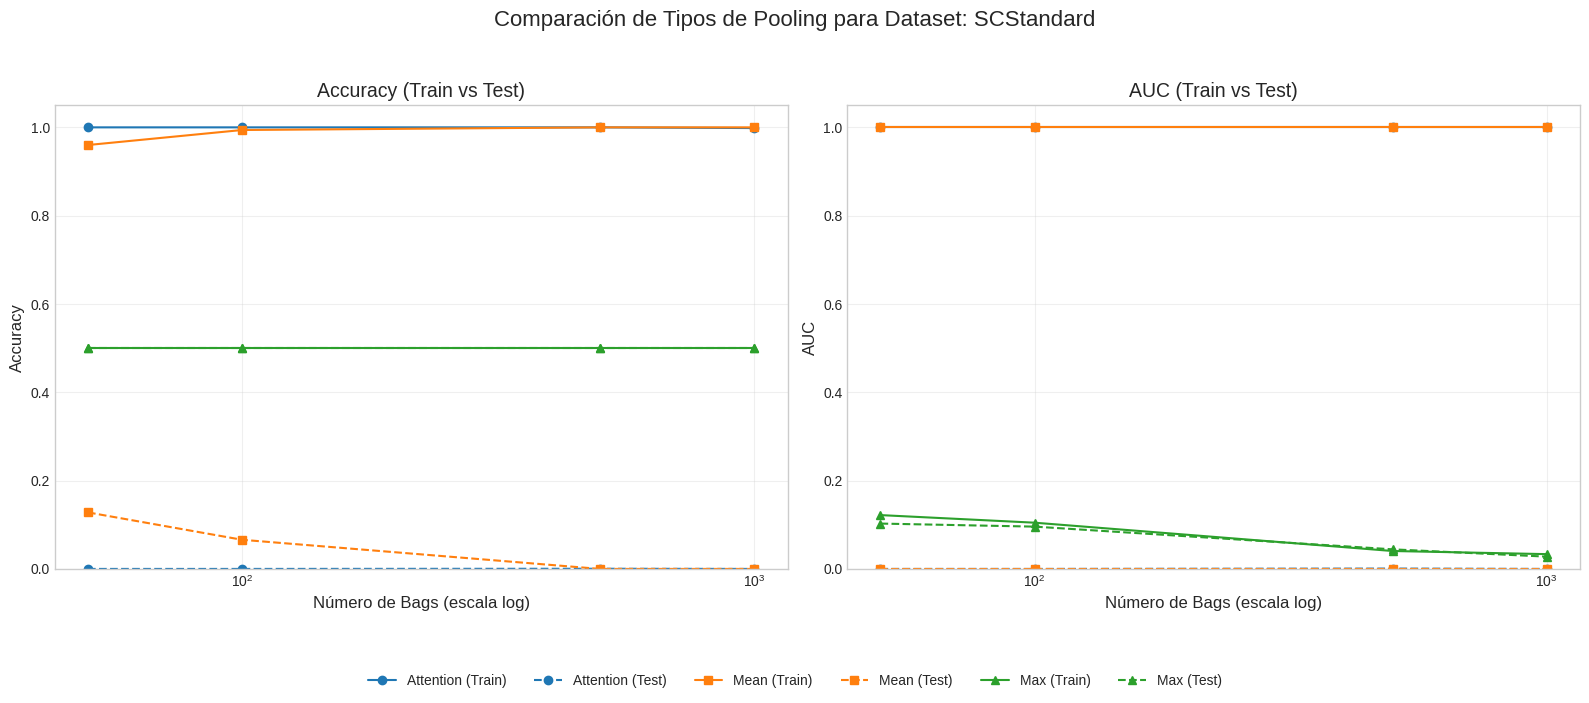

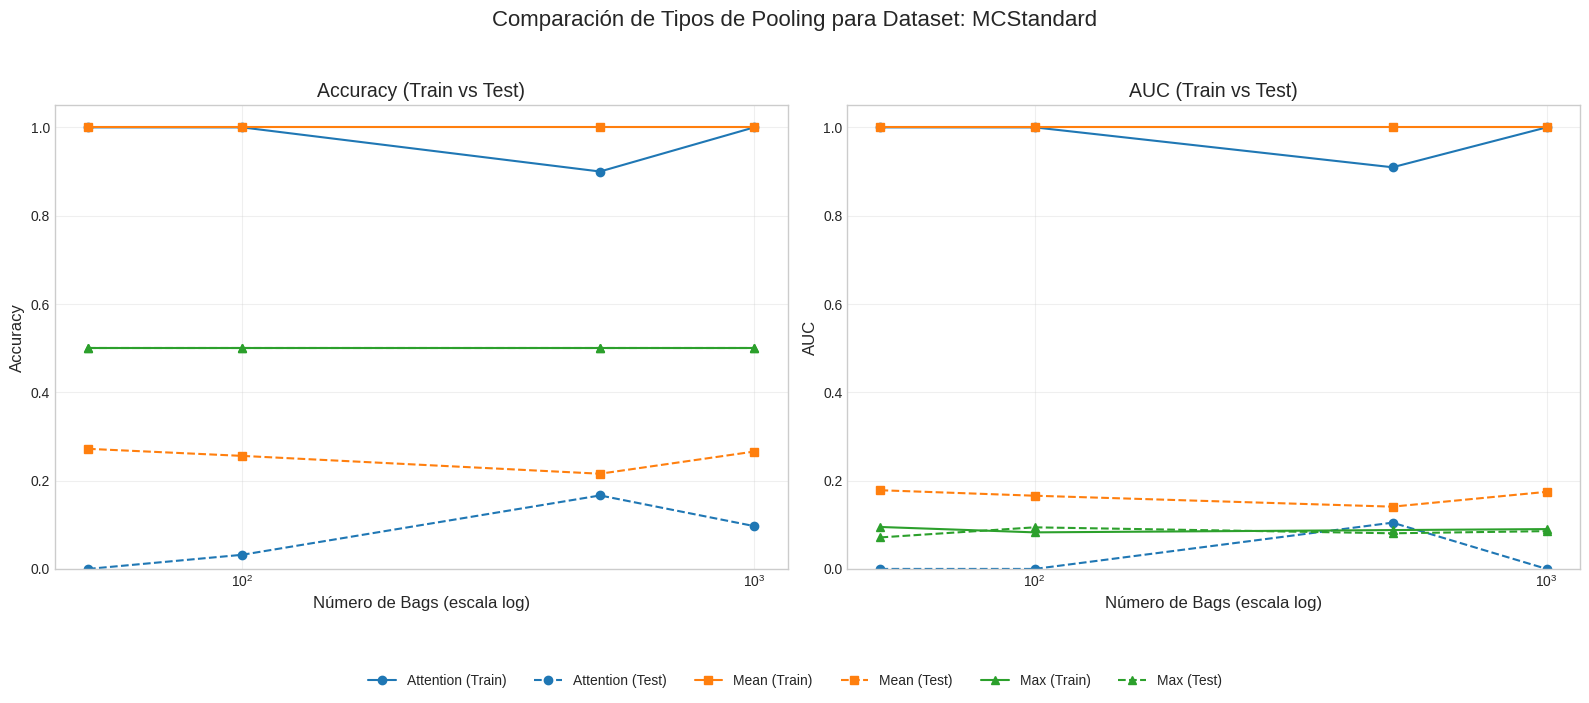

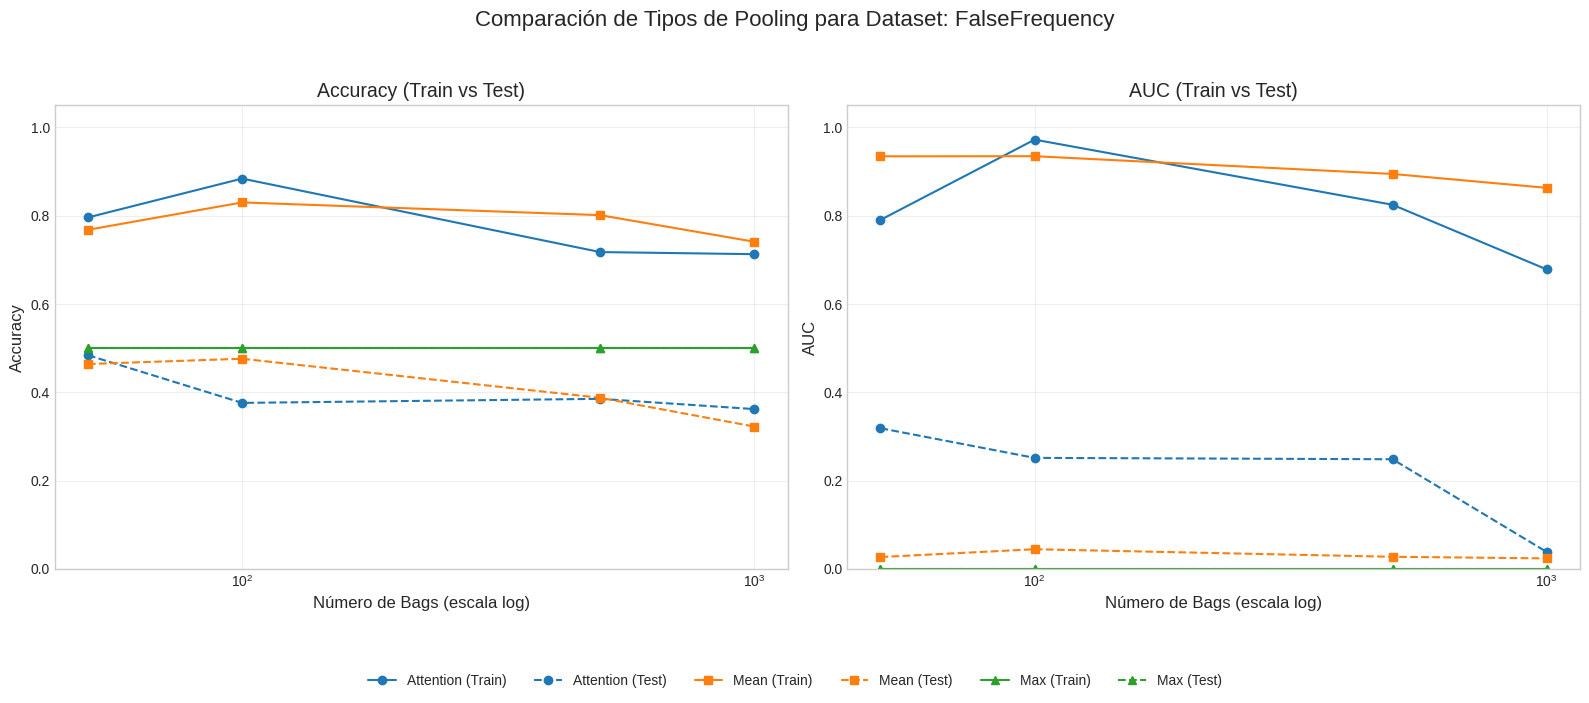

<Figure size 1800x1000 with 0 Axes>

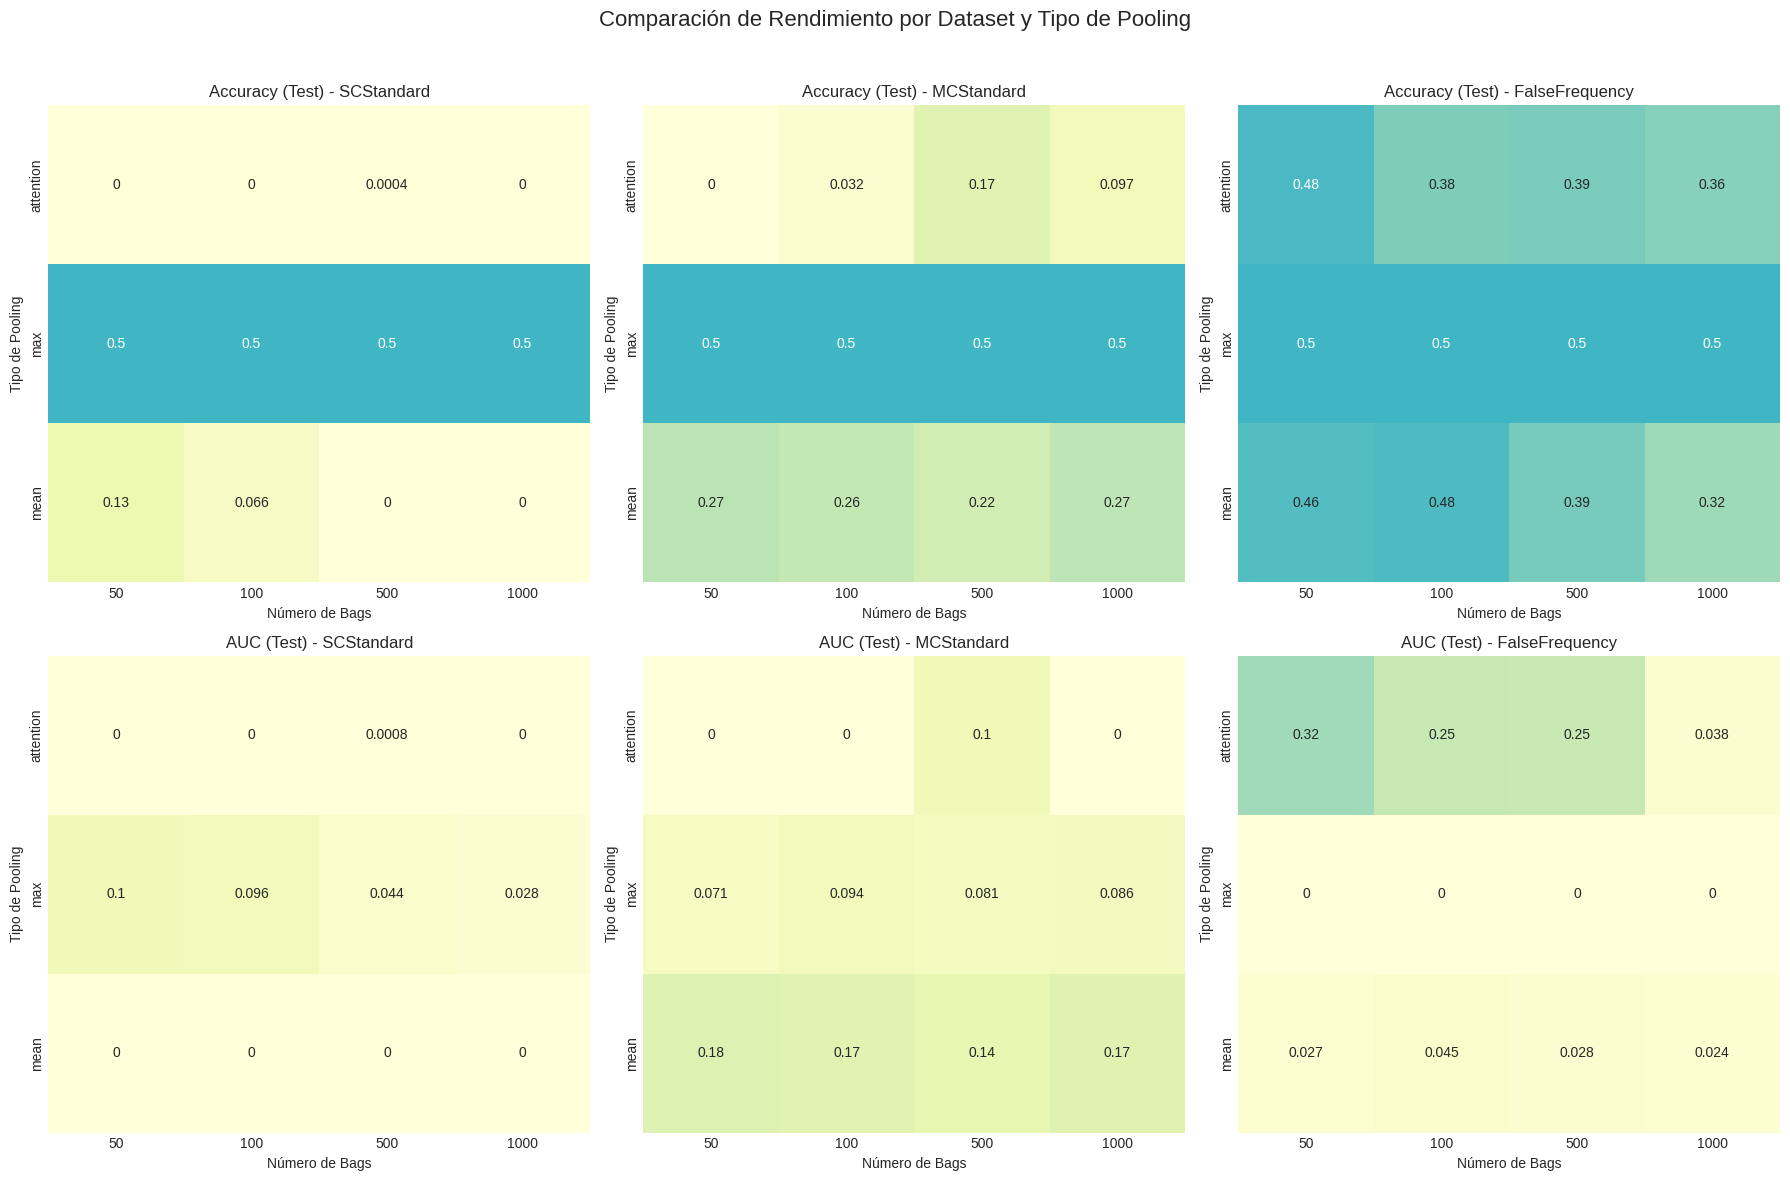

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el archivo CSV
df = pd.read_csv('suposiciones.csv')

# Configurar el estilo
plt.style.use('seaborn-v0_8-whitegrid')
colors = {'attention': '#1f77b4', 'mean': '#ff7f0e', 'max': '#2ca02c'}
markers = {'attention': 'o', 'mean': 's', 'max': '^'}

# Función para crear gráficas por dataset
def plot_by_dataset(dataset_name):
    # Filtrar datos por dataset
    data = df[df['dataset'] == dataset_name]
    
    # Crear figura con 2 subplots (accuracy y auc)
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Título principal
    fig.suptitle(f'Comparación de Tipos de Pooling para Dataset: {dataset_name}', fontsize=16)
    
    # Lista de tipos de pooling
    pooling_types = data['pooling_type'].unique()
    
    # Gráfica para Accuracy
    for pooling in pooling_types:
        pooling_data = data[data['pooling_type'] == pooling]
        axes[0].plot(pooling_data['n_bags'], pooling_data['accuracy_train'], 
                  color=colors[pooling], marker=markers[pooling], linestyle='-', 
                  label=f'{pooling.capitalize()} (Train)')
        axes[0].plot(pooling_data['n_bags'], pooling_data['accuracy_test'], 
                  color=colors[pooling], marker=markers[pooling], linestyle='--',
                  label=f'{pooling.capitalize()} (Test)')
    
    axes[0].set_xscale('log')
    axes[0].set_xlabel('Número de Bags (escala log)', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Accuracy (Train vs Test)', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1.05)
    
    # Gráfica para AUC
    for pooling in pooling_types:
        pooling_data = data[data['pooling_type'] == pooling]
        axes[1].plot(pooling_data['n_bags'], pooling_data['auc_train'], 
                  color=colors[pooling], marker=markers[pooling], linestyle='-', 
                  label=f'{pooling.capitalize()} (Train)')
        axes[1].plot(pooling_data['n_bags'], pooling_data['auc_test'], 
                  color=colors[pooling], marker=markers[pooling], linestyle='--',
                  label=f'{pooling.capitalize()} (Test)')
    
    axes[1].set_xscale('log')
    axes[1].set_xlabel('Número de Bags (escala log)', fontsize=12)
    axes[1].set_ylabel('AUC', fontsize=12)
    axes[1].set_title('AUC (Train vs Test)', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1.05)
    
    # Leyenda única
    handles, labels = axes[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', 
              bbox_to_anchor=(0.5, 0.05), ncol=len(by_label), fontsize=10)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

# Ejecutar visualizaciones
# 1. Gráficas por dataset
for dataset in ['SCStandard', 'MCStandard', 'FalseFrequency']:
    plot_by_dataset(dataset)

# 2. Heatmaps para comparar rendimiento por dataset
plt.figure(figsize=(18, 10))

# Crear una matriz para organizar los subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación de Rendimiento por Dataset y Tipo de Pooling', fontsize=16)

metrics = ['accuracy_test', 'auc_test']
metric_names = ['Accuracy (Test)', 'AUC (Test)']
datasets = ['SCStandard', 'MCStandard', 'FalseFrequency']

for i, metric in enumerate(metrics):
    for j, dataset in enumerate(datasets):
        # Filtrar datos
        data = df[df['dataset'] == dataset]
        
        # Crear DataFrame pivotado para la visualización
        pivot_data = data.pivot(index='pooling_type', columns='n_bags', values=metric)
        
        # Crear heatmap
        sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', vmin=0, vmax=1, 
                   ax=axes[i, j], cbar=False)
        
        axes[i, j].set_title(f'{metric_names[i]} - {dataset}')
        axes[i, j].set_ylabel('Tipo de Pooling')
        axes[i, j].set_xlabel('Número de Bags')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()